# LOAY RASHID 2018102008

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
import numpy as np
import cv2
from glob import glob
import os
from collections import OrderedDict
import pickle

In [129]:
def loadImages(train_image, test_image, paths):
    for path in paths:
        # get training images
        train_img, test_img = [], []
        for img_file_name in glob(train + path + "/*.jpg"):
            img = cv2.imread(img_file_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            train_img.append(img)
        # get test images
        for img_file_name in glob(test + path + "/*.jpg"):
            img = cv2.imread(img_file_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            test_img.append(img)
        train_image[path]=train_img
        test_image[path]=test_img
    return train_image, test_image

def sift_extractFeatures(sift, images):
    desc, vectors = [], OrderedDict()
    for category, images_list in images.items():
        vectors[category] = []
        for img in images_list:
            _, des = sift.detectAndCompute(img, None)
            desc.extend(des)
            vectors[category].append(des)
    desc= np.asarray(desc)
    return desc.astype(np.float32), vectors

def denseSift_extractFeatures(sift, images):
    desc, sift_vectors = np.empty(shape = (0, 128)), OrderedDict()
    step_size = 5
    for category, images_list in images.items():
        for img in images_list:
            # plt.imshow(img)
            sift_vectors[category] = []
            r, c = img.shape
            keyp = [cv2.KeyPoint(x, y, step_size) for y in range(0, r, step_size) for x in range(0, c, step_size)]
            des = sift.compute(img , keyp)[1]
            if des is None:
                continue
            desc = np.append(desc, des, axis = 0)
            sift_vectors[category].append(des)
    return desc.astype(np.float32), sift_vectors

def bovwHistogram(norm, fileIndexes, vectors, kmeans):
    histogramFeatures = []
    labels = []
    for category, imageFeatures in vectors.items():
        for imageDesc in imageFeatures:
            histogram = np.zeros(shape = kmeans.n_clusters)
            feats = kmeans.predict(imageDesc).astype(int)
            for i in feats:
                histogram[i] += 1
            labels.append(fileIndexes[category])
            if norm:
                histogram /= np.sum(histogram)
            histogramFeatures.append(histogram)
    return np.array(histogramFeatures), np.array(labels)

def preprocess(k, norm, filePaths, fileIndexes, train, test):
    train_image, test_image = OrderedDict(), OrderedDict()
    train_image, test_image = loadImages(train_image, test_image, filePaths)

    print("training sift")
    sift = cv2.xfeatures2d.SIFT_create()
    train_desc, train_vec = sift_extractFeatures(sift, train_image)
    _, test_vec = sift_extractFeatures(sift, test_image)
    print("sift done")

    print("running kmeans")
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters = k).fit(train_desc.astype(np.float32))
    print("kmeans done, generating hists") 
    bovw_train, labels_train = bovwHistogram(norm, fileIndexes, train_vec, kmeans)
    bovw_test, labels_test = bovwHistogram(norm, fileIndexes, test_vec, kmeans)
    return bovw_train, labels_train, bovw_test, labels_test

In [50]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

def trainClassifier(bovw_train, labels_train, model_file):
    clf = OneVsRestClassifier(svm.SVC()).fit(bovw_train, labels_train)
    with open(model_file, "wb") as f: 
        pickle.dump(clf, f)
    return

def testClassifier(bovw_test, model_file):
    with open(model_file, "rb") as f: 
        clf = pickle.load(f)
    predictions = clf.predict(bovw_test)
    return predictions.astype(int)

In [81]:
from sklearn import metrics
import matplotlib.pyplot as plt
def plotImages(prediction, groundTruth, filePaths, test_path):
    matches = np.where(prediction == groundTruth)[0]
    unmatches = np.where(prediction != groundTruth)[0]
    test_images=[]
    for path in filePaths:
        for img_file_name in glob(test_path + path + "/*.jpg"):
            img = cv2.imread(img_file_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            test_images.append(img)
    print(len(test_images))
    for i in np.random.choice(matches, size = 2).astype(int):
        if i>=len(test_images):
            continue
        print("predicted: " + filePaths[prediction[i]])
        print("actual: " + filePaths[groundTruth[i]])
        # print(i)
        plt.imshow(test_images[i])
        plt.axis('off')
        plt.show()
    for i in np.random.choice(unmatches, size = 2).astype(int):
        if i>=len(test_images):
            continue
        print("predicted: " + filePaths[prediction[i]])
        print("actual: " + filePaths[groundTruth[i]])
        # print(i)
        plt.imshow(test_images[i])
        plt.axis('off')
        plt.show()

In [90]:
def main(k, norm, svm_op, train, test):
    filePaths = os.listdir(train) 
    fileIndexes = {filePaths[i]:i for i in range(len(filePaths))}
    bovw_train, labels_train, bovw_test, labels_test = preprocess(k, norm, filePaths, fileIndexes, train, test)
    print("preprocess done")
    trainClassifier(bovw_train, labels_train, svm_op)
    print("svm train done")
    predicted = testClassifier(bovw_test, svm_op)
    print("svm prediction done")
    print("confusion matrix: ",metrics.confusion_matrix(labels_test, predicted))
    print("accuracy: ",metrics.accuracy_score(labels_test, predicted))
    plotImages(predicted, labels_test, filePaths, test)

# k=10, not normalized
accuracy = 41.25

training sift
sift done
running kmeans
kmeans done, generating hists
preprocess done
svm train done
svm prediction done
confusion matrix:  [[6 2 1 0 0 1 0 0]
 [0 9 0 0 0 1 0 0]
 [5 1 1 0 0 0 0 3]
 [1 2 0 1 1 1 2 2]
 [2 0 0 0 7 0 0 1]
 [4 3 0 0 1 0 1 1]
 [0 4 0 0 1 0 5 0]
 [2 0 0 1 1 0 2 4]]
accuracy:  0.4125
predicted op: kitchen
actual op: kitchen


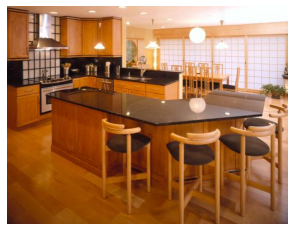

predicted op: park
actual op: park


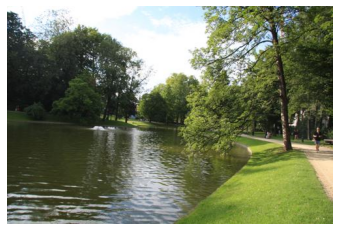

predicted op: park
actual op: waterfall


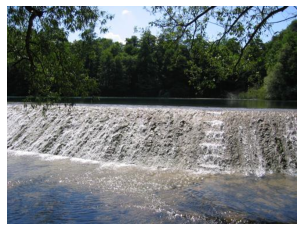

predicted op: park
actual op: windmill


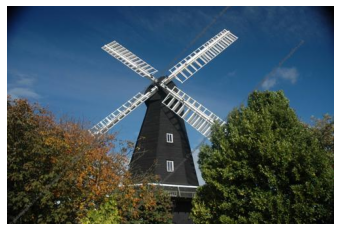

In [91]:
train, test, svm_op = "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/Simpler/train/", "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/Simpler/test/", "/content/70_wo_norm.pkl"
main(10, False, svm_op, train, test)

# Accuracies achieved:
k=100, with Normalization: 56.25

k=100, without normalization: 50

k=50, with Normalization: 43.75

k=50, without normalization: 42.5

# k=100, w Normalization
Accuracy: 56.25



training sift
sift done
running kmeans
kmeans done, generating hists
preprocess done
svm train done
svm prediction done
confusion matrix:  [[9 0 1 0 0 0 0 0]
 [0 7 0 0 0 0 3 0]
 [5 0 4 0 1 0 0 0]
 [1 0 1 3 1 1 2 1]
 [0 0 3 0 6 0 0 1]
 [2 1 0 1 3 3 0 0]
 [0 2 0 1 0 0 7 0]
 [0 1 0 0 3 0 0 6]]
accuracy:  0.5625
predicted op: park
actual op: park


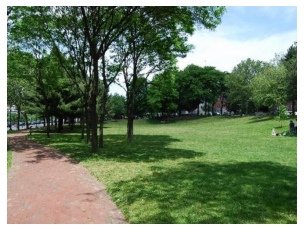

predicted op: desert
actual op: desert


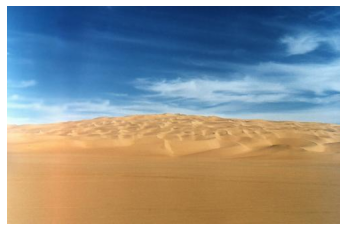

predicted op: windmill
actual op: highway


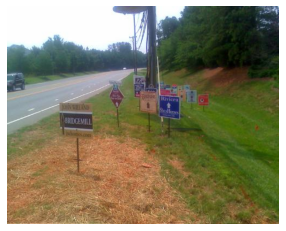

predicted op: desert
actual op: aquarium


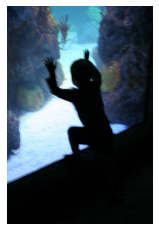

In [16]:
svm_op="/content/k_100_norm.pkl"
main(100, True, svm_op, train = "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/Simpler/train/", test = "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/Simpler/test/")

# k=100, without Normalization
Accuracy: 50

training sift
sift done
running kmeans
kmeans done, generating hists
preprocess done
svm train done
svm prediction done
confusion matrix:  [[6 0 4 0 0 0 0 0]
 [2 5 0 0 0 0 2 1]
 [5 0 4 0 0 1 0 0]
 [2 1 1 2 1 1 2 0]
 [2 0 1 0 7 0 0 0]
 [4 0 0 1 2 3 0 0]
 [0 3 0 0 0 0 6 1]
 [2 0 0 0 1 0 0 7]]
accuracy:  0.5
predicted op: park
actual op: park


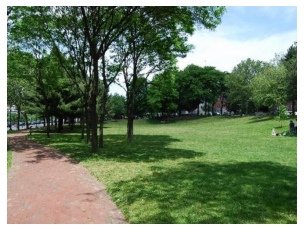

predicted op: waterfall
actual op: waterfall


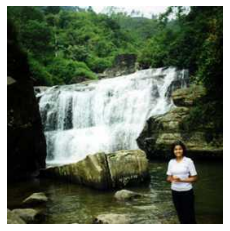

predicted op: park
actual op: desert


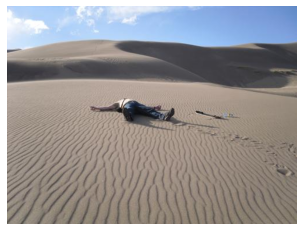

predicted op: park
actual op: windmill


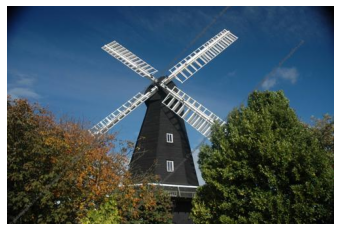

In [17]:
svm_op="/content/k_100.pkl"
main(100, False, svm_op, train = "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/Simpler/train/", test = "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/Simpler/test/")

# k=50, with Normalization
Accuracy: 43.75

training sift
sift done
running kmeans
kmeans done, generating hists
preprocess done
svm train done
svm prediction done
confusion matrix:  [[9 0 0 0 0 1 0 0]
 [0 5 1 1 0 1 2 0]
 [5 0 4 0 1 0 0 0]
 [2 1 1 2 1 1 1 1]
 [0 0 2 1 6 0 0 1]
 [4 2 0 0 3 1 0 0]
 [1 5 0 1 0 1 2 0]
 [0 1 0 0 3 0 0 6]]
accuracy:  0.4375
predicted op: waterfall
actual op: waterfall


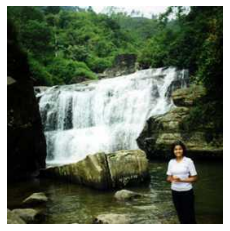

predicted op: laundromat
actual op: laundromat


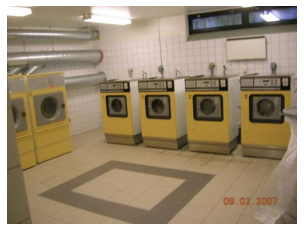

predicted op: desert
actual op: windmill


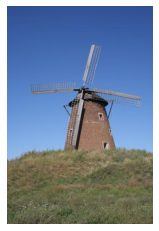

predicted op: park
actual op: highway


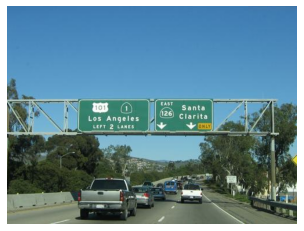

In [92]:
svm_op="/content/k_50_norm.pkl"
main(50, True, svm_op, train = "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/Simpler/train/", test = "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/Simpler/test/")

# k=50, without Normalization
Accuracy: 42.5

training sift
sift done
running kmeans
kmeans done, generating hists
preprocess done
svm train done
svm prediction done
confusion matrix:  [[6 0 4 0 0 0 0 0]
 [3 5 0 0 0 0 1 1]
 [5 0 3 1 0 0 0 1]
 [2 2 0 1 1 2 2 0]
 [2 0 1 0 6 0 0 1]
 [4 0 0 1 2 3 0 0]
 [0 3 0 2 1 0 4 0]
 [2 1 0 0 1 0 0 6]]
accuracy:  0.425
predicted op: laundromat
actual op: laundromat


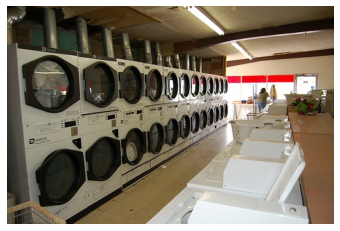

predicted op: laundromat
actual op: laundromat


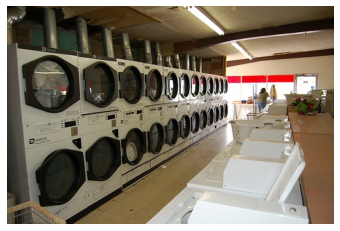

predicted op: desert
actual op: aquarium


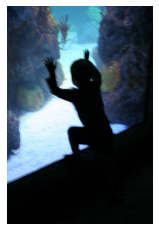

predicted op: laundromat
actual op: highway


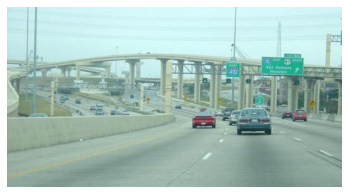

In [93]:
svm_op="/content/k_50.pkl"
main(50, False, svm_op, train = "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/Simpler/train/", test = "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/Simpler/test/")

# Output on entire dataset:
k= 50 without normalization accuracy: 51.25

In [102]:
train = "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/train/" 
test = "/content/drive/MyDrive/IIITH Assignments 3-2/CV/SUN_data/test/"
svm_op = "/content/k_50_big.pkl"
filePaths_big = os.listdir(train) 
fileIndexes_big = {filePaths_big[i]:i for i in range(len(filePaths_big))}
bovw_train_big, labels_train_big, bovw_test_big, labels_test_big = preprocess(50, False, filePaths_big, fileIndexes_big, train, test)
print("preprocess done")

training sift
sift done
running kmeans
kmeans done, generating hists
preprocess done


In [103]:
trainClassifier(bovw_train_big, labels_train_big, svm_op)
print("svm train done")

svm train done


In [104]:
predicted_big = testClassifier(bovw_test_big, svm_op)
print("svm prediction done")

svm prediction done


confusion matrix:  [[15  1  2  1  0  0  1  0]
 [ 0 12  2  0  1  3  0  2]
 [ 0  1 16  1  0  1  0  1]
 [ 1  1  0  8  1  3  4  2]
 [ 0  6  1  3  3  0  0  7]
 [ 0 10  1  0  0  9  0  0]
 [12  0  2  2  0  0  4  0]
 [ 0  1  0  1  0  3  0 15]]
accuracy:  0.5125
predicted op: kitchen
actual op: kitchen


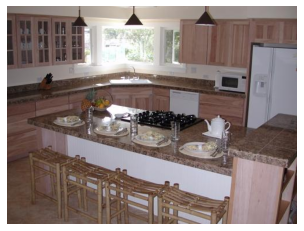

predicted op: aquarium
actual op: aquarium


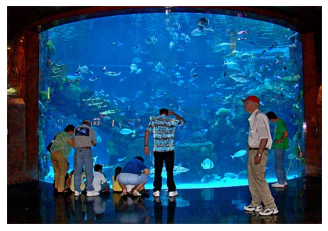

predicted op: kitchen
actual op: windmill


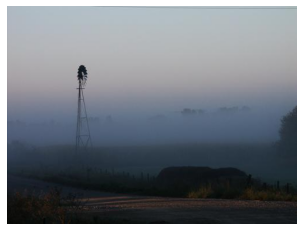

predicted op: kitchen
actual op: windmill


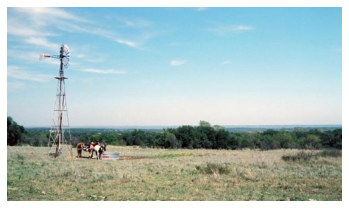

In [105]:
print("confusion matrix: ",metrics.confusion_matrix(labels_test_big, predicted_big))
print("accuracy: ",metrics.accuracy_score(labels_test_big, predicted_big))
plotImages(predicted_big, labels_test_big, filePaths, test)

In [97]:
print("mks")

mks
